### INSTALLATION

In [1]:
!pip install wandb
!pip install scikit-multilearn

In [60]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove.6B/

ERROR: Operation cancelled by user
--2024-12-13 03:48:17--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-13 03:48:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1        3%[                    ]  28.12M  17.1MB/s               ^C
Archive:  glove.6B.zip
replace glove.6B/glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### IMPORTING LIBRARIES

In [19]:
import wandb
import nltk
nltk.download('reuters')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import reuters
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from nltk import PorterStemmer, WordNetLemmatizer
import re
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

import torch
from torch import optim
from torch import nn
from torch.nn.utils import clip_grad_norm_

from sklearn.metrics import hamming_loss, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb

from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

import time
import matplotlib.pyplot as plt
import seaborn as sns
from skmultilearn.problem_transform import LabelPowerset
from sklearn.multioutput import ClassifierChain
import copy
from scipy.sparse import csr_matrix
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from gensim.models import Word2Vec
import os
from typing import Tuple, List
from functools import partial

from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, BertPreTrainedModel
from sklearn.metrics import roc_auc_score


if not sys.warnoptions:
    warnings.simplefilter("ignore")


[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### EDA

In [20]:
docs = nltk.corpus.reuters.fileids()
labels = [nltk.corpus.reuters.categories(doc) for doc in docs]
texts = [nltk.corpus.reuters.raw(doc) for doc in docs]
mlb = MultiLabelBinarizer()
bin_labels = mlb.fit_transform(labels)
label_names = mlb.classes_

In [21]:
df = pd.DataFrame({'text': texts})
for i, label in enumerate(label_names):
    df[label] = bin_labels[:, i]

print(df.head())
labels = df.columns[1:]
X_train = df['text']
# X_test = test_df['comment_text']
y_train = df.iloc[:,1:]

                                                text  acq  alum  barley  bop  \
0  ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...    0     0       0    0   
1  CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...    0     0       0    0   
2  JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...    0     0       0    0   
3  THAI TRADE DEFICIT WIDENS IN FIRST QUARTER\n  ...    0     0       0    0   
4  INDONESIA SEES CPO PRICE RISING SHARPLY\n  Ind...    0     0       0    0   

   carcass  castor-oil  cocoa  coconut  coconut-oil  ...  sun-oil  sunseed  \
0        0           0      0        0            0  ...        0        0   
1        0           0      0        0            0  ...        0        0   
2        0           0      0        0            0  ...        0        0   
3        0           0      0        0            0  ...        0        0   
4        0           0      0        0            0  ...        0        0   

   tea  tin  trade  veg-oil  wheat  wpi  yen  zinc

In [22]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

stemmer = SnowballStemmer("english")

def plot_len_of_sentences(text_cols):
    comment_len = text_cols.len()

    # plot the distribution of comment lengths
    plt.figure(figsize=(8,4))
    sns.histplot(comment_len, kde=False, bins=50, color="red")
    plt.xlabel("Comment Length (Number of words)", fontsize=12)
    plt.ylabel("Number of Comments", fontsize=12)
    plt.title("Distribution of comment Lengths", fontsize=12)

    print("Average comment length:",int(sum(comment_len)/len(comment_len))," characters")

def plot_bar_graph(train_df,labels,title):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_axes([0,0,1,1])
    total_count = []
    for label in labels:
        total_count.append(len(train_df[train_df[label] == 1]))
    ax.bar(labels,total_count, color=['red', 'green', 'blue', 'purple', 'orange', 'yellow'])
    for i,data in enumerate(total_count):
        plt.text(i-.25,
                data/total_count[i]+100,
                total_count[i],
                fontsize=12)
    plt.title(title)
    plt.xlabel('Labels')
    plt.ylabel('Number of comments')

def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

def lemmatize(sentence):
    lemmatizer = WordNetLemmatizer()
    lemSentence = ""
    for word in sentence.split():
        lem = lemmatizer.lemmatize(word)
        lemSentence += lem
        lemSentence += " "
    lemSentence = lemSentence.strip()
    return lemSentence

def preprocess_text(train_df):
    train_df['comment_text'] = train_df['comment_text'].str.lower()
    train_df['comment_text'] = train_df['comment_text'].apply(cleanHtml)
    train_df['comment_text'] = train_df['comment_text'].apply(cleanPunc)
    train_df['comment_text'] = train_df['comment_text'].apply(keepAlpha)
    train_df['comment_text'] = train_df['comment_text'].apply(removeStopWords)
    train_df['comment_text'] = train_df['comment_text'].apply(lemmatize)
    return train_df

def sample_dataset(train_df):
    df = train_df[train_df['clean']==0]
    df = pd.concat([df, train_df[train_df['clean'] == 1].sample(frac=1, random_state=200).iloc[:df.shape[0], :]], ignore_index=True)
    df = df.sample(frac=1,random_state=200)
    return df

def create_glove_embedding_matrix(tokenizer, glove_file_path):
    glove_embeddings = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            glove_embeddings[word] = vector

    vocab_size = len(tokenizer.index_word) + 1
    #File 300 dim expected
    embedding_dim = 300
    glove_embedding_matrix = torch.zeros(vocab_size, embedding_dim)

    unknown_words = 0
    for i in range(1, vocab_size):
        word = tokenizer.index_word[i]
        if word in glove_embeddings.keys():
            glove_embedding_matrix[i] = torch.from_numpy(glove_embeddings[word]).float()
        else:
            unknown_words += 1

    print("GloVe embedding matrix created!")
    print('Vocabulary size: {}'.format(vocab_size))
    print('Total unknown words: {}'.format(unknown_words))

    return glove_embeddings, glove_embedding_matrix

def create_glove_label_embedding(labels, glove_embeddings):
    glove_label_embedding = torch.zeros(len(labels), 300)

    for index, label in enumerate(labels):
        wrds = label.split('_')
        for l in wrds:
            if l in glove_embeddings.keys():
                glove_label_embedding[index] += torch.from_numpy(glove_embeddings[l])
        glove_label_embedding[index] /= len(wrds)

    return glove_label_embedding

def get_bert_embedding_matrix(tokenizer):
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    vocab_size = len(tokenizer.index_word)+1
    bert_embedding_matrix = torch.zeros(vocab_size, 768)


    tokens_tensor=[]
    for i in tqdm(range(1, vocab_size)):
        word = tokenizer.index_word[i]
        tokens = bert_tokenizer.encode(word,add_special_tokens=False)[0]
        tokens_tensor.append(tokens)
    batch_size = 512
    vocab_batches = [tokens_tensor[i:i+batch_size] for i in range(0, len(tokens_tensor), batch_size)]

    with torch.no_grad():
      bert_embeddings = []
      for i in tqdm(range(len(vocab_batches))):
        batch = vocab_batches[i]
        inputs = {
        'input_ids': torch.tensor([batch]),
        'attention_mask': torch.ones(len(batch)).unsqueeze(0)
        }
        outputs = bert_model(**inputs)
        batch_embeddings = outputs[0][0]
        bert_embeddings.append(batch_embeddings)

    bert_embedding_matrix = torch.cat(bert_embeddings, dim=0)
    return bert_embedding_matrix


#Build adjacency matrix based on Co-Occurencies label
def create_adjacency_matrix_cooccurance(data_label):
  cooccur_matrix = np.zeros((data_label.shape[1], data_label.shape[1]), dtype=float)
  for y in data_label:
      y = list(y)
      for i in range(len(y)):
          for j in range(len(y)):
            #data_label
              if y[i] == 1 and y[j] == 1:
                  cooccur_matrix[i, j] += 1
  row_sums = data_label.sum(axis=0)

  for i in range(cooccur_matrix.shape[0]):
    for j in range(cooccur_matrix.shape[0]):
      if row_sums[i]!=0:
        cooccur_matrix[i][j]=cooccur_matrix[i,j]/row_sums[i]
      else:
        cooccur_matrix[i][j]=cooccur_matrix[i,j]

  return cooccur_matrix


def check_accuracy(model, label_embedding, X, y):
  model.eval()
  with torch.no_grad():
    out = model(X, label_embedding)
    y_pred = torch.sigmoid(out.detach()).round().cpu()
    f1score = f1_score(y, y_pred, average='micro')
    hammingloss = hamming_loss(y, y_pred)
  return hammingloss, f1score

class dataset(Dataset):
  def __init__(self, x, y):
    self.x  = x
    self.y = y
  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]


In [23]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(cleanHtml)
df['text'] = df['text'].apply(cleanPunc)
df['text'] = df['text'].apply(keepAlpha)
df['text'] = df['text'].apply(removeStopWords)
df['text'] = df['text'].apply(lemmatize)

df.head()

,text,acq,alum,barley,bop,carcass,castor-oil,cocoa,coconut,coconut-oil,...,sun-oil,sunseed,tea,tin,trade,veg-oil,wheat,wpi,yen,zinc
0,asian exporter fear damage u japan rift mounti...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,china daily say vermin eat pct grain stock sur...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,japan revise long term energy demand downwards...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,thai trade deficit widens first quarter thaila...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,indonesia see cpo price rising sharply indones...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


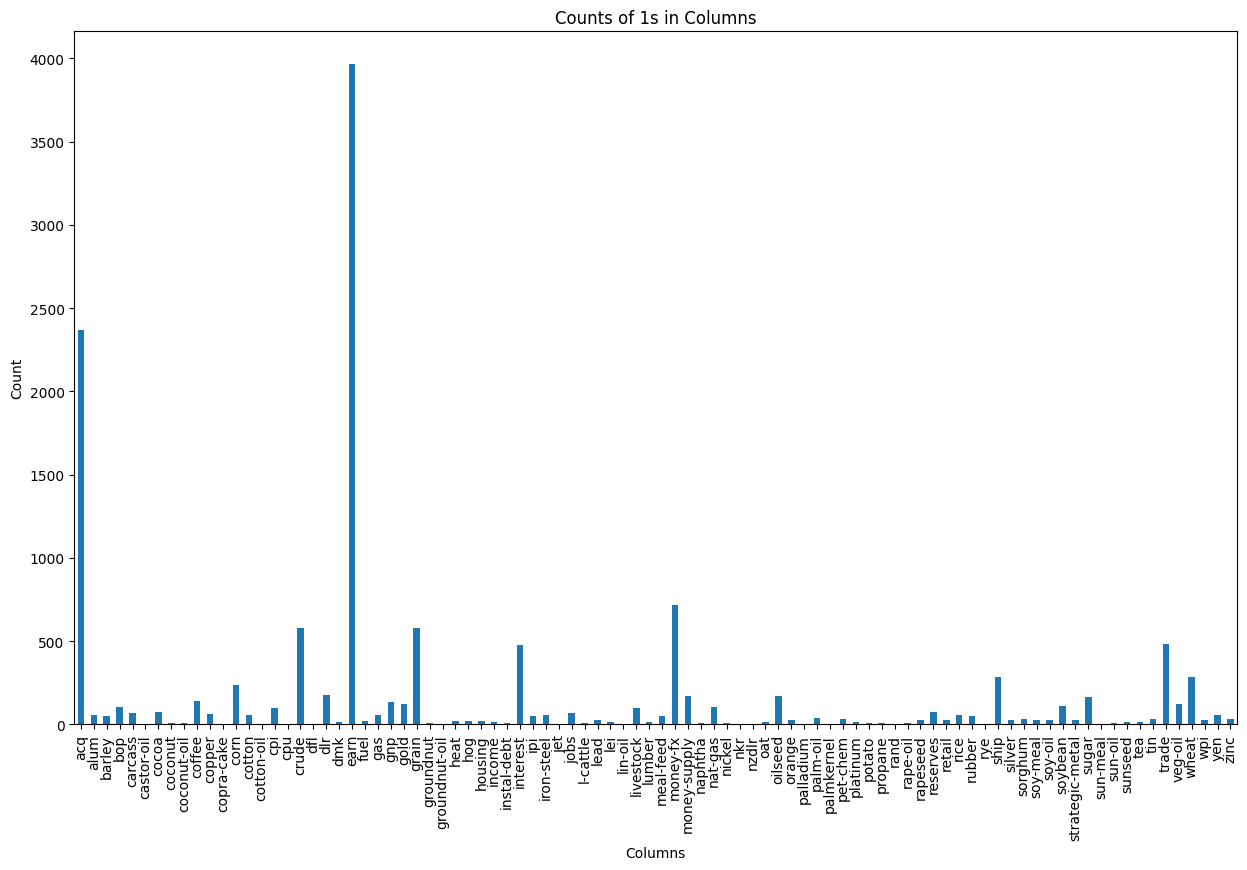

In [24]:
# filter the DataFrame to include only numeric columns
numeric_df = df.select_dtypes(include=['int', 'float'])
# count the number of 1's in each column
counts = numeric_df.sum()
# create a bar chart of the counts with a larger figure size
fig = plt.figure(figsize=(15, 9))
counts.plot(kind='bar')
# add chart labels
plt.title('Counts of 1s in Columns')
plt.xlabel('Columns')
plt.ylabel('Count')
# display the chart
plt.show()

In [25]:
X = df['text'].values
y = df.iloc[:,1:].values
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=200)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(10788,) (10788, 90)
(8630,) (2158,) (8630, 90) (2158, 90)


### MODEL

In [26]:
def train(model, X_train, label_embedding, y_train,
          total_epoch=250, batch_size=250, learning_rate=0.001,
          save_path='./model.pt', state=None):

    wandb.init(
        project="magnet-classification",
        config={
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "epochs": total_epoch,
            "architecture": "MAGNET"
        }
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    label_embedding = label_embedding.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_data = DataLoader(dataset(X_train, y_train), batch_size=batch_size)

    best_loss = float('inf')
    num_increasing_epochs = 0

    for epoch in range(1, total_epoch + 1):
        running_loss = 0
        y_pred = []
        epoch_time = 0
        model.train()

        for index, (X, y) in enumerate(train_data):
            optimizer.zero_grad()
            out = model(X.to(device), label_embedding)
            loss = criterion(out, y.to(device).float())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
            optimizer.step()
            y_pred.append(torch.sigmoid(out.detach()).round().cpu())
            running_loss += loss.item()

        y_pred = torch.vstack(y_pred)
        f1score = f1_score(y_train, y_pred, average='micro')
        hammingloss = hamming_loss(y_train, y_pred)

        wandb.log({
            "epoch": epoch,
            "loss": running_loss,
            "hamming_loss": hammingloss,
            "micro_f1_score": f1score
        })

        print(f'epoch:{epoch} loss:{running_loss:.5f} hamming_loss:{hammingloss:.5f} micro_f1score:{f1score:.5f}')


In [27]:
class MAGNET(nn.Module):
  def __init__(self, input_size, hidden_size, adjacency, embeddings, heads=4, slope=0.01, dropout=0.5):
    super(MAGNET, self).__init__()
    self.embedding = nn.Embedding.from_pretrained(embeddings)
    self.biLSTM = nn.LSTM(input_size,hidden_size,batch_first=True,bidirectional=True)
    self.adjacency = nn.Parameter(adjacency)
    self.dropout = nn.Dropout(dropout)
    self.edge_weights = nn.Linear(hidden_size*2*2, 1, bias=False)
    self.activation = nn.LeakyReLU(slope)
    self.softmax = nn.Softmax(dim=1)
    self.tanh = nn.Tanh()
    self.heads = heads
    self.transform_dim1 = nn.Linear(input_size, hidden_size*2, bias=False)
    self.transform_dim2 = nn.Linear(hidden_size*2, hidden_size*2, bias=False)
    self.transform_dimensions = [self.transform_dim1, self.transform_dim2]

  def forward(self, token, label_embedding):
      #BILSTM part
      features = self.embedding(token)
      out, (h, _) = self.biLSTM(features)
      embedding = torch.cat([h[-2, :, :], h[-1, :, :]], dim=1)
      embedding = self.dropout(embedding)

      #GAT PART
      for td in self.transform_dimensions: #Two Multiheaded GAT layers
        outputs = []
        for head in range(self.heads):
          label_embed = td(label_embedding)
          n, embed_size = label_embed.shape

          label_embed_combinations = label_embed.unsqueeze(1).expand(-1, n, -1)
          label_embed_combinations = torch.cat([label_embed_combinations, label_embed.unsqueeze(0).expand(n, -1, -1)], dim=2)
          e = self.activation(self.edge_weights(label_embed_combinations).squeeze(2))

          attention_coefficients = self.tanh(torch.mul(e,self.adjacency))

          new_h = torch.matmul(attention_coefficients.to(label_embed.dtype), label_embed)
          outputs.append(new_h)
        outputs = self.activation(torch.mean(torch.stack(outputs, dim=0),dim=0))

        label_embedding = outputs
      attention_features = self.dropout(label_embedding)
      attention_features = attention_features.transpose(0, 1)
      predicted_labels = torch.matmul(embedding, attention_features)
      return predicted_labels

### TRAINING

In [28]:
tokenizer = Tokenizer(num_words=20000,oov_token='<UNK>')
tokenizer.fit_on_texts(X_train)
sequences_text_train = tokenizer.texts_to_sequences(X_train)
sequences_text_test = tokenizer.texts_to_sequences(X_test)

X_train = torch.from_numpy(pad_sequences(sequences_text_train, maxlen=70))
X_test = torch.from_numpy(pad_sequences(sequences_text_test, maxlen=70))

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )
print(len(tokenizer.index_word))

torch.Size([8630, 70]) torch.Size([2158, 70]) torch.Size([8630, 90]) torch.Size([2158, 90])
24629


In [29]:
#Load glove embedding
glove_embeddings = {}
with open('glove.6B/glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        glove_embeddings[word] = vector

VOCAB_SIZE = len(tokenizer.index_word)+1
glove_embedding_matrix = torch.zeros(VOCAB_SIZE, 300)

unk = 0
for i in range(1, VOCAB_SIZE):
  word = tokenizer.index_word[i]
  if word in glove_embeddings.keys():
    glove_embedding_matrix[i] = torch.from_numpy(glove_embeddings[word]).float()
  else:
    unk +=1
print('VOCAB_SIZE : {}'.format(VOCAB_SIZE))
print('TOTAL OF UNKNOWN WORD : {}'.format(unk))

VOCAB_SIZE : 24630
TOTAL OF UNKNOWN WORD : 4664


In [30]:
adj_matrix = create_adjacency_matrix_cooccurance(y_train.numpy())
adj_matrix = torch.tensor(adj_matrix)
adj_matrix

tensor([[1.0000e+00, 5.2910e-04, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0582e-03],
        [2.2222e-02, 1.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.2222e-02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [7.4074e-02, 3.7037e-02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0000e+00]], dtype=torch.float64)

In [31]:
glove_label_embedding = torch.zeros(len(labels),300)

for index, label in enumerate(labels):
  wrds = label.split('-')
  for l in wrds:
    if l in glove_embeddings.keys():
        glove_label_embedding[index] +=  torch.from_numpy(glove_embeddings[l])
  glove_label_embedding[index]=glove_label_embedding[index]/len(wrds)

print(glove_label_embedding)

tensor([[ 0.1796, -0.1051, -0.5564,  ..., -0.0633,  0.3732, -0.2873],
        [ 0.1101,  0.4061,  0.2036,  ..., -0.1957, -0.4627,  0.6931],
        [-0.3568, -0.1348,  0.0790,  ..., -0.0384,  0.2948,  0.1996],
        ...,
        [-0.1446,  0.0594, -0.1450,  ..., -0.0334,  0.1966,  0.4136],
        [-0.5990, -0.3234, -0.2749,  ...,  0.6343,  0.5300,  0.0299],
        [-0.4541, -0.1300, -0.5178,  ..., -1.1637, -0.2056, -0.3177]])


In [32]:
save_path = './train_result.pt'

In [33]:
model = MAGNET(300, 250, adj_matrix, glove_embedding_matrix,heads=8)
train(model, X_train, glove_label_embedding,y_train,total_epoch=100, save_path=save_path)

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
hamming_loss,█▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
micro_f1_score,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████████████
epoch,100
hamming_loss,0.00096
loss,0.08944
micro_f1_score,0.96514


epoch:1 loss:5.80905 hamming_loss:0.02695 micro_f1score:0.02678
epoch:2 loss:1.62403 hamming_loss:0.01205 micro_f1score:0.27343
epoch:3 loss:1.37418 hamming_loss:0.01036 micro_f1score:0.41219
epoch:4 loss:1.25059 hamming_loss:0.01030 micro_f1score:0.42842
epoch:5 loss:1.17409 hamming_loss:0.01021 micro_f1score:0.44597
epoch:6 loss:1.07930 hamming_loss:0.00986 micro_f1score:0.49412
epoch:7 loss:0.95959 hamming_loss:0.00802 micro_f1score:0.62758
epoch:8 loss:0.91755 hamming_loss:0.00763 micro_f1score:0.64753
epoch:9 loss:0.89148 hamming_loss:0.00746 micro_f1score:0.65893
epoch:10 loss:0.84249 hamming_loss:0.00723 micro_f1score:0.67189
epoch:11 loss:0.84736 hamming_loss:0.00719 micro_f1score:0.67379
epoch:12 loss:0.81002 hamming_loss:0.00712 micro_f1score:0.67758
epoch:13 loss:0.78793 hamming_loss:0.00702 micro_f1score:0.68272
epoch:14 loss:0.76126 hamming_loss:0.00693 micro_f1score:0.69082
epoch:15 loss:0.75253 hamming_loss:0.00695 micro_f1score:0.68940
epoch:16 loss:0.72486 hamming_loss

### EVALUATING


In [34]:
def evaluate(model, X_test, label_embedding, y_test, batch_size=250):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_data = DataLoader(dataset(X_test, y_test), batch_size=batch_size)

    y_pred = []
    test_loss = 0
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for X, y in test_data:
            out = model(X.to(device), label_embedding.to(device))
            loss = criterion(out, y.to(device).float())
            test_loss += loss.item()
            y_pred.append(torch.sigmoid(out).round().cpu())

    y_pred = torch.vstack(y_pred)

    # Calculate metrics
    f1_micro = f1_score(y_test, y_pred, average='micro')
    hammingloss = hamming_loss(y_test, y_pred)

    print(f"Test Results:")
    print(f"Loss: {test_loss:.5f}")
    print(f"Micro F1: {f1_micro:.5f}")
    print(f"Hamming Loss: {hammingloss:.5f}")

    return y_pred, test_loss

# Usage:
# First load your saved model if necessary
# model.load_state_dict(torch.load(save_path))
predictions, test_loss = evaluate(model, X_test, glove_label_embedding, y_test)

Test Results:
Loss: 0.36823
Micro F1: 0.84394
Hamming Loss: 0.00402
